<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет
Признаки
RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата
Целевой признак
Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
#изучим данные
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


(10000, 14)

In [5]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [6]:
data.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [7]:
data[data['Tenure'].isna()]['Exited'].value_counts()

0    726
1    183
Name: Exited, dtype: int64

Столбцы RowNumber, CustomerId, Surname можно удалить, так как они не нужны в исследовании и не несут полезной для нас информации

In [8]:
data_cleared = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_cleared.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
#Посмотрим имеются ли у нас дубликаты 
data_cleared.duplicated().sum()

0

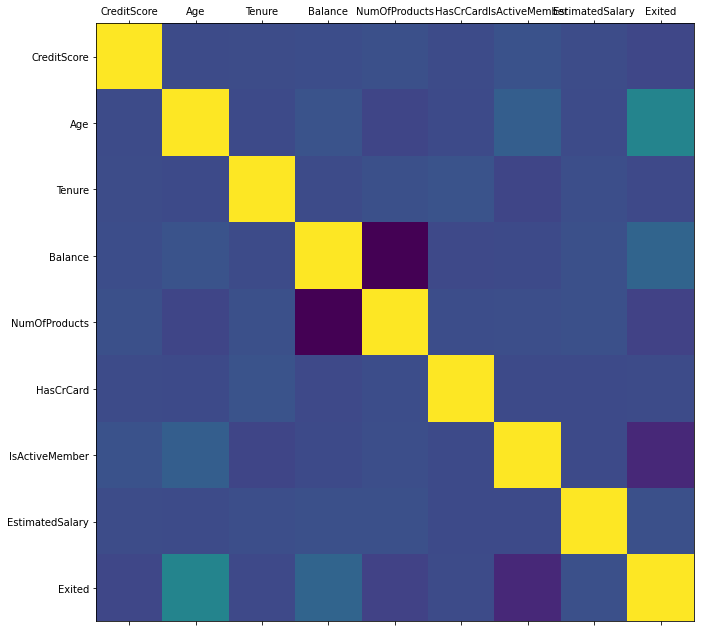

In [10]:
def plot_corr(df, size=11):
  corr = df.corr()
  fig, ax = plt.subplots(figsize=(size,size))
  ax.matshow(corr)
  plt.xticks(range(len(corr.columns)), corr.columns)
  plt.yticks(range(len(corr.columns)), corr.columns)

plot_corr(data_cleared)

<div class="alert alert-block alert-info">
<b>Совет:</b> Напомню, что корреляция спирмена/пирсона подходит только для количественных факторов. Советую обратить на инструмент <a href="https://phik.readthedocs.io/en/latest/" >phik</a>, который помогает устанавливать связи (не только линейные) между факторами (и не только между количественными)

In [11]:
#Изменим тип данных у столбца Tenure и заполним пустые значения с помощью SimpleImputer из библиотеки sklearn
data_cleared['Tenure'] = data_cleared['Tenure'].replace(np.NaN, None).astype(int,errors='ignore').astype(object)
imputer = SimpleImputer(strategy='constant')
imp_data = pd.DataFrame(imputer.fit_transform(data_cleared))
imp_data.columns = data_cleared.columns

#Проверим как сработал SimpleImputer
data_cleared['Tenure'].isnull().sum()

0

In [12]:
#Проведем кодирование с помощью OHE
data_cleared = pd.get_dummies(data_cleared, drop_first=True)

#Стандартизируем признаки с помощью StandardScaler
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler.fit(data_cleared[numeric])
data_cleared[numeric] = scaler.transform(data_cleared[numeric])

In [13]:
data_cleared.head()

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,...,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10
0,-0.326221,0.293517,-1.225848,1,1,1,0.021886,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.440036,0.198164,0.117350,1,0,1,0.216534,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,-1.536794,0.293517,1.333053,3,1,0,0.240687,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.501521,0.007457,-1.225848,2,0,0,-0.108918,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2.063884,0.388871,0.785728,1,1,1,-0.365276,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [14]:
#С помощью train_test_split Разделим наш датасет на следующие выборки 
X = data_cleared.drop(['Exited'], axis=1)
y = data_cleared['Exited']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

print('Training set size:', X_train.shape[0])
print('Validating set size:', X_valid.shape[0])
print('Test set size:',X_test.shape[0])

Training set size: 6000
Validating set size: 2000
Test set size: 2000


Вывод:
Изучили наш датасет
Нашли пустые значения в столбце Tenure, заполнили их с помощью SimpleImputer
Дубликатов не выявили
Просмотрели матрицу корреляции, никаких взаимосвязей мещающих нашим будущим моделям не выявили
Провели кодирование и стандартизировали признаки с помощью StandardScaler
Разделили наш датасет на выборки : обучающую, валидационную и тестовую

## Исследование задачи

In [15]:
# Модель RandomForestClassifier со стандартными параметрами, посмотрим какой аккураси и f1score покажет нам модель
model = RandomForestClassifier(random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))
confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.8455
F1_Score is: 0.5224111282843895


array([[1522,   55],
       [ 254,  169]])

In [16]:
# Модель logisticRegression со стандартными параметрами, посмотрим какой аккураси и f1score покажет нам модель
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))
print('ROC_AUC score is', roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

#confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.789
F1_Score is: 0.2673611111111111
ROC_AUC score is 0.7381103360811667


## Борьба с дисбалансом

In [18]:
for depth,estimator in itertools.product(range(1,30,10), range(1,151,50)):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    score = accuracy_score(predictions, y_valid)
    fscore = f1_score(y_valid, predictions)
    print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}'.format(depth, estimator))
    print('Accuracy: {: >5.4f}   |   F1_Score: {: >5.4f}'.format(score,fscore))
    print('------------------------------------------------------')

Depth:     1       |   Estimators:     1
Accuracy: 0.6785   |   F1_Score: 0.4819
------------------------------------------------------
Depth:     1       |   Estimators:    51
Accuracy: 0.7375   |   F1_Score: 0.4937
------------------------------------------------------
Depth:     1       |   Estimators:   101
Accuracy: 0.7345   |   F1_Score: 0.5238
------------------------------------------------------
Depth:    11       |   Estimators:     1
Accuracy: 0.7370   |   F1_Score: 0.5130
------------------------------------------------------
Depth:    11       |   Estimators:    51
Accuracy: 0.8360   |   F1_Score: 0.6010
------------------------------------------------------
Depth:    11       |   Estimators:   101
Accuracy: 0.8395   |   F1_Score: 0.6109
------------------------------------------------------
Depth:    21       |   Estimators:     1
Accuracy: 0.7750   |   F1_Score: 0.4375
------------------------------------------------------
Depth:    21       |   Estimators:    51
Accurac

При глубине деревьев 11 и числе деревьев 51. F1_score показал наилучший результат : 0.6034 и accuracy_score : 0.8350. Попробуем улучшить показатели

In [19]:
#Попробуем обучить нашу модель с помощью увеличения выборки

def upsampling(features, target, repeat):
    X_zeros = X_train[y_train == 0]
    X_ones = X_train[y_train == 1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled


X_upsampled, y_upsampled = upsampling(X_train, y_train, 4)

model = RandomForestClassifier(random_state=12345)
model.fit(X_upsampled, y_upsampled)
predictions = model.predict(X_valid)
print("F1_Score: {: >5.3f}  |   Repeats : {: >5.0f}".format(f1_score(y_valid, predictions), 4))

F1_Score: 0.572  |   Repeats :     4


In [20]:
#Попробуем обучить нашу модель с помощью уменьшения выборки

def downsampling(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

X_downsampled, y_downsampled = downsampling(X_train, y_train, 1/4)
model = RandomForestClassifier(random_state=12345)
model.fit(X_downsampled, y_downsampled)
predictions = model.predict(X_valid)
print("F1_Score: {: >5.3f}  |  Fractions : {: >5.3f}".format(f1_score(y_valid, predictions), 1/4))

F1_Score: 0.575  |  Fractions : 0.250


не совсем понял в чем ошибка :(

## Тестирование модели

In [21]:
# Испробуем нашу модель на тестовой выборке с соответствующими параметрами
model = RandomForestClassifier(n_estimators = 51, max_depth=11, class_weight='balanced', random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_test)

accuracy_valid = accuracy_score(predicted_valid, y_test)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_test, predicted_valid))

Accuracy is: 0.8445
F1_Score is: 0.6230303030303032


In [22]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.8514160501817698

Подготовили датасет для прогнозирования оттока клиентов

Использовали две модели : RandomForestClassifier и LogisticRegression, на начальном этапе LogisticRegression показал наихудшие результаты, поэтому мы выбрали RandomForestClassifier для дальнейшей работы.

Попробовали увеличить и уменьшить выборки для увеличения f1_score, но наибольшее, что мы получили это f1_score : 0.56.

Требуемое задание выполнили, но применив метод подбора количества деревьев и глубины леса через цикл мы нашли наилучшие параметры для Случайного Леса и получили F1_score : 0.62

получили roc auc score : 85, что значительно больше случайного порога в 0.5. Наша модель предсказывает достаточно хорошо.

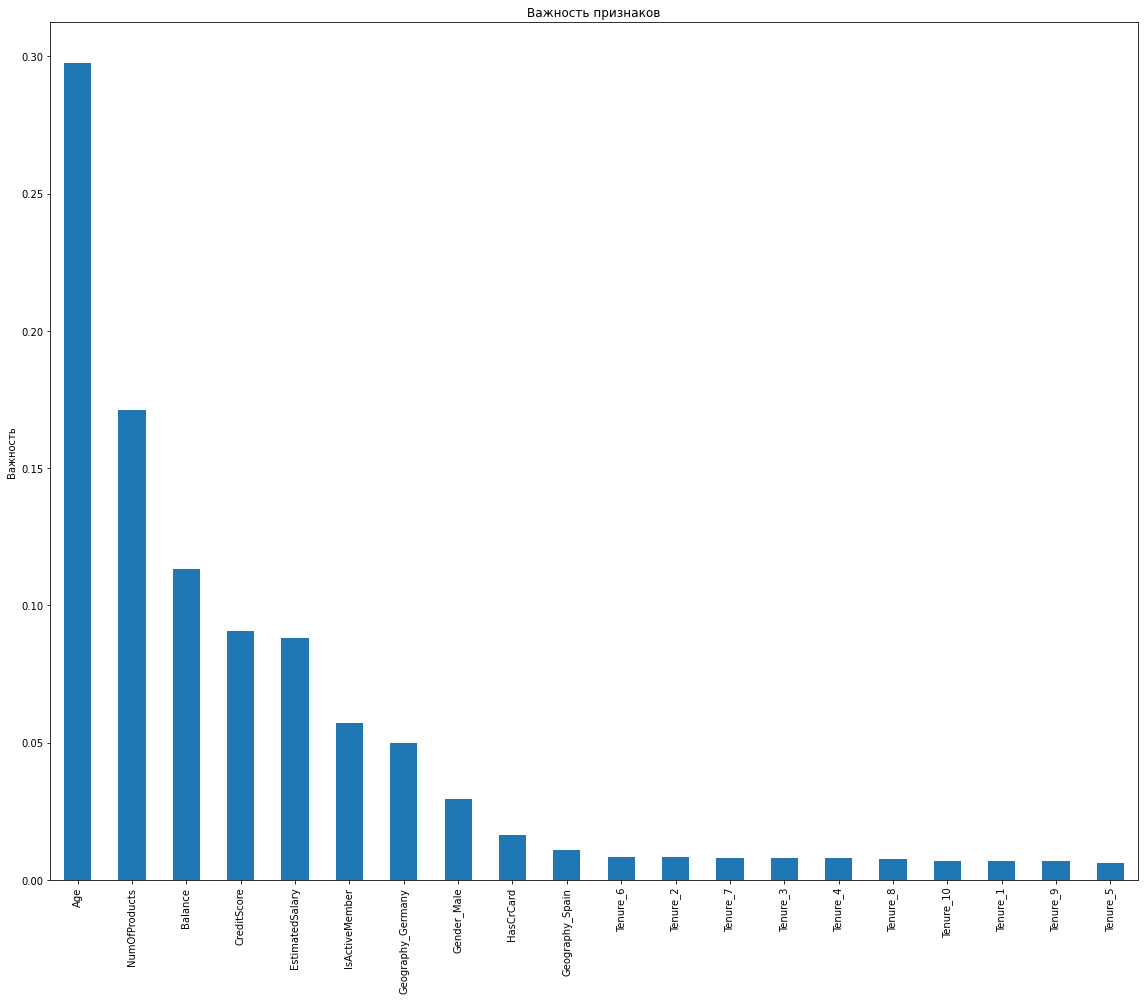

In [26]:
forest_imp = pd.Series(model.feature_importances_,
                        X_test.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16,14))
forest_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*